# Compute the mean structural similarity index between two images
https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity

Registration accuracy was computed by estimating the structural similarity indexing method SSIM. This method calculates a map for objective observation of similarities and detection of differences in structural information between two images. We used the SSIM map to automatically evaluate spatial registration accuracy. SSIM ranges from -1 (dissimilar e.g. misaligned) to 1 (similar, aligned). SSIM was processed using the template JHU18m FA image as reference image and for the 3 registration approaches the registered PMD FA image as moving (transformed) image in the JHU18m template space for similarity comparison.


In [1]:
import bids
import os
from os.path import abspath, dirname, join
import nibabel as nib
from scipy.stats import ranksums, ttest_rel
from os.path import abspath, dirname
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.legend as legend
from nilearn.plotting import plot_anat
from matplotlib import axes as Axes
from pandas import read_excel
#%matplotlib notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)
from wmi_nipype_workflows.wmi_nipype_workflows.utils import bids_labels
from nilearn.image import image
from nilearn.plotting import view_img, displays, plot_roi, plot_anat, show
from matplotlib.pyplot import imshow, show, figure
import numpy as np

In [2]:
projectdir = dirname(dirname(abspath('__file__')))
indexer=bids.layout.index.BIDSLayoutIndexer(validate=False, ignore=['code','sourcedata','tmp','tmp_mapnode'])
layout = bids.BIDSLayout(os.path.dirname(os.getcwd()), derivatives=True, validate=False, indexer=indexer)


In [3]:
#https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity
# calculate the structural similarity index for 3 different registration methods
# SSIM is based on luminescence, contrast and structure for voxel groups
# SSIM ranges from -1 imperfect similarity to 1 (perfect similarity)
from skimage.metrics import structural_similarity

# generate a patient list
pat={'PMD1': '0m',
     'PMD2': '6m',
     'PMD3': '0m',
     'PMD4': '0m',
     'PMD5': '0m',
    }
# fixed image for SSIM (atlas)
fix = join(projectdir,'code','templates','JHU_pediatric','18month','JHU_pediatric18_SS_fa_ss_lps.nii.gz')
im1 =  nib.load(fix).get_fdata()
ssim={'subject': [],'session': [], 'method':[], 'mean_ssim': [], 'ssim_map': []}

for sub, ses in pat.items():
    # load registered (moving images) for diferent modalities
    mov= {
            'fa' : join(projectdir,'derivatives','coreg_jhu_fa',f'sub-{sub}',f'ses-{ses}','anat',f'sub-{sub}_ses-{ses}_space-jhu_desc-regFA_fa.nii.gz'),
            'multimod' : join(projectdir,'derivatives','coreg_jhu_multimod',f'sub-{sub}',f'ses-{ses}','anat',f'sub-{sub}_ses-{ses}_space-jhu_desc-regmultimod_fa.nii.gz'),
            't1w' :  join(projectdir,'derivatives', 'coreg_jhu_t1w',f'sub-{sub}',f'ses-{ses}','anat',f'sub-{sub}_ses-{ses}_space-jhu_desc-regT1w_fa.nii.gz')
         }
    # calc ssim maps
    for k, v  in mov.items():
        im2 =  nib.load(v).get_fdata()
    
        (mean_ssim,ssim_map) = structural_similarity(im1, im2,  win_size=None, gradient=False, data_range=2, channel_axis=None, multichannel=False, gaussian_weights=True, full=True)
        #s
        # dict of ssim mean ssim across whole brainmask
        ssim['subject'].append(sub)
        ssim['session'].append(ses)
        ssim['method'].append(k)
        ssim['mean_ssim'].append(mean_ssim)
        ssim['ssim_map'].append(ssim_map)


In [4]:
#save ssim maps
fixi=nib.load(fix)
path=join(projectdir, 'derivatives', 'similarity_maps')
if not os.path.exists(path):
    os.makedirs(path)
for count, sub in enumerate(ssim['subject']):
    ses= ssim['session'][count]
    method= ssim['method'][count]
    filename= join(path, f'sub-{sub}_ses-{ses}_desc-{method}_ssimmap.nii.gz')
    nib.save(nib.Nifti1Image(ssim['ssim_map'][count], fixi.affine, header=fixi.header), filename)

In [5]:
# create a dataset_description.json for derivatives 'jhu18m_to_pmd_t1w'
import time
import json
__version__ = "0.2"
with open(join(layout.root, 'derivatives', 'similarity_maps', 'dataset_description.json'), 'w') as f:
    f.write(json.dumps({
                'Name': 'ssim map files in template space',
                'BIDSVersion': '1.4.0',
                'DatasetType': 'derivative',
                'GeneratedBy': [{'caroline.koehler@ukdd.de': '2_calculate_SSIM.ipynb'}],
    }))

with open(join(layout.root, 'derivatives', 'similarity_maps', 'CHANGELOG'), 'a') as f:
    f.write('\n')
    f.write(time.strftime("%Y-%m-%d:"))
    f.write('\t-Running reg_template Workflow')
# update layout otherwise jhu18m_to_pmd_t1w files are not found)
try:
    layout.add_derivatives(path= join(layout.root, 'derivatives', 'similarity_maps'))
    print ('writing dataset_description for derivatives similarity_maps')

except:
    print('dataset_description exists ')

dataset_description exists 


### The SSIM maps are displayed for PMD1 for the three registration methods.

/opt/conda/lib/python3.9/site-packages/nilearn/plotting/html_stat_map.py:111: UserWarning: Threshold given was 1e-06, but the data has no values below -0.7687332630157471. 
  warnings.warn(



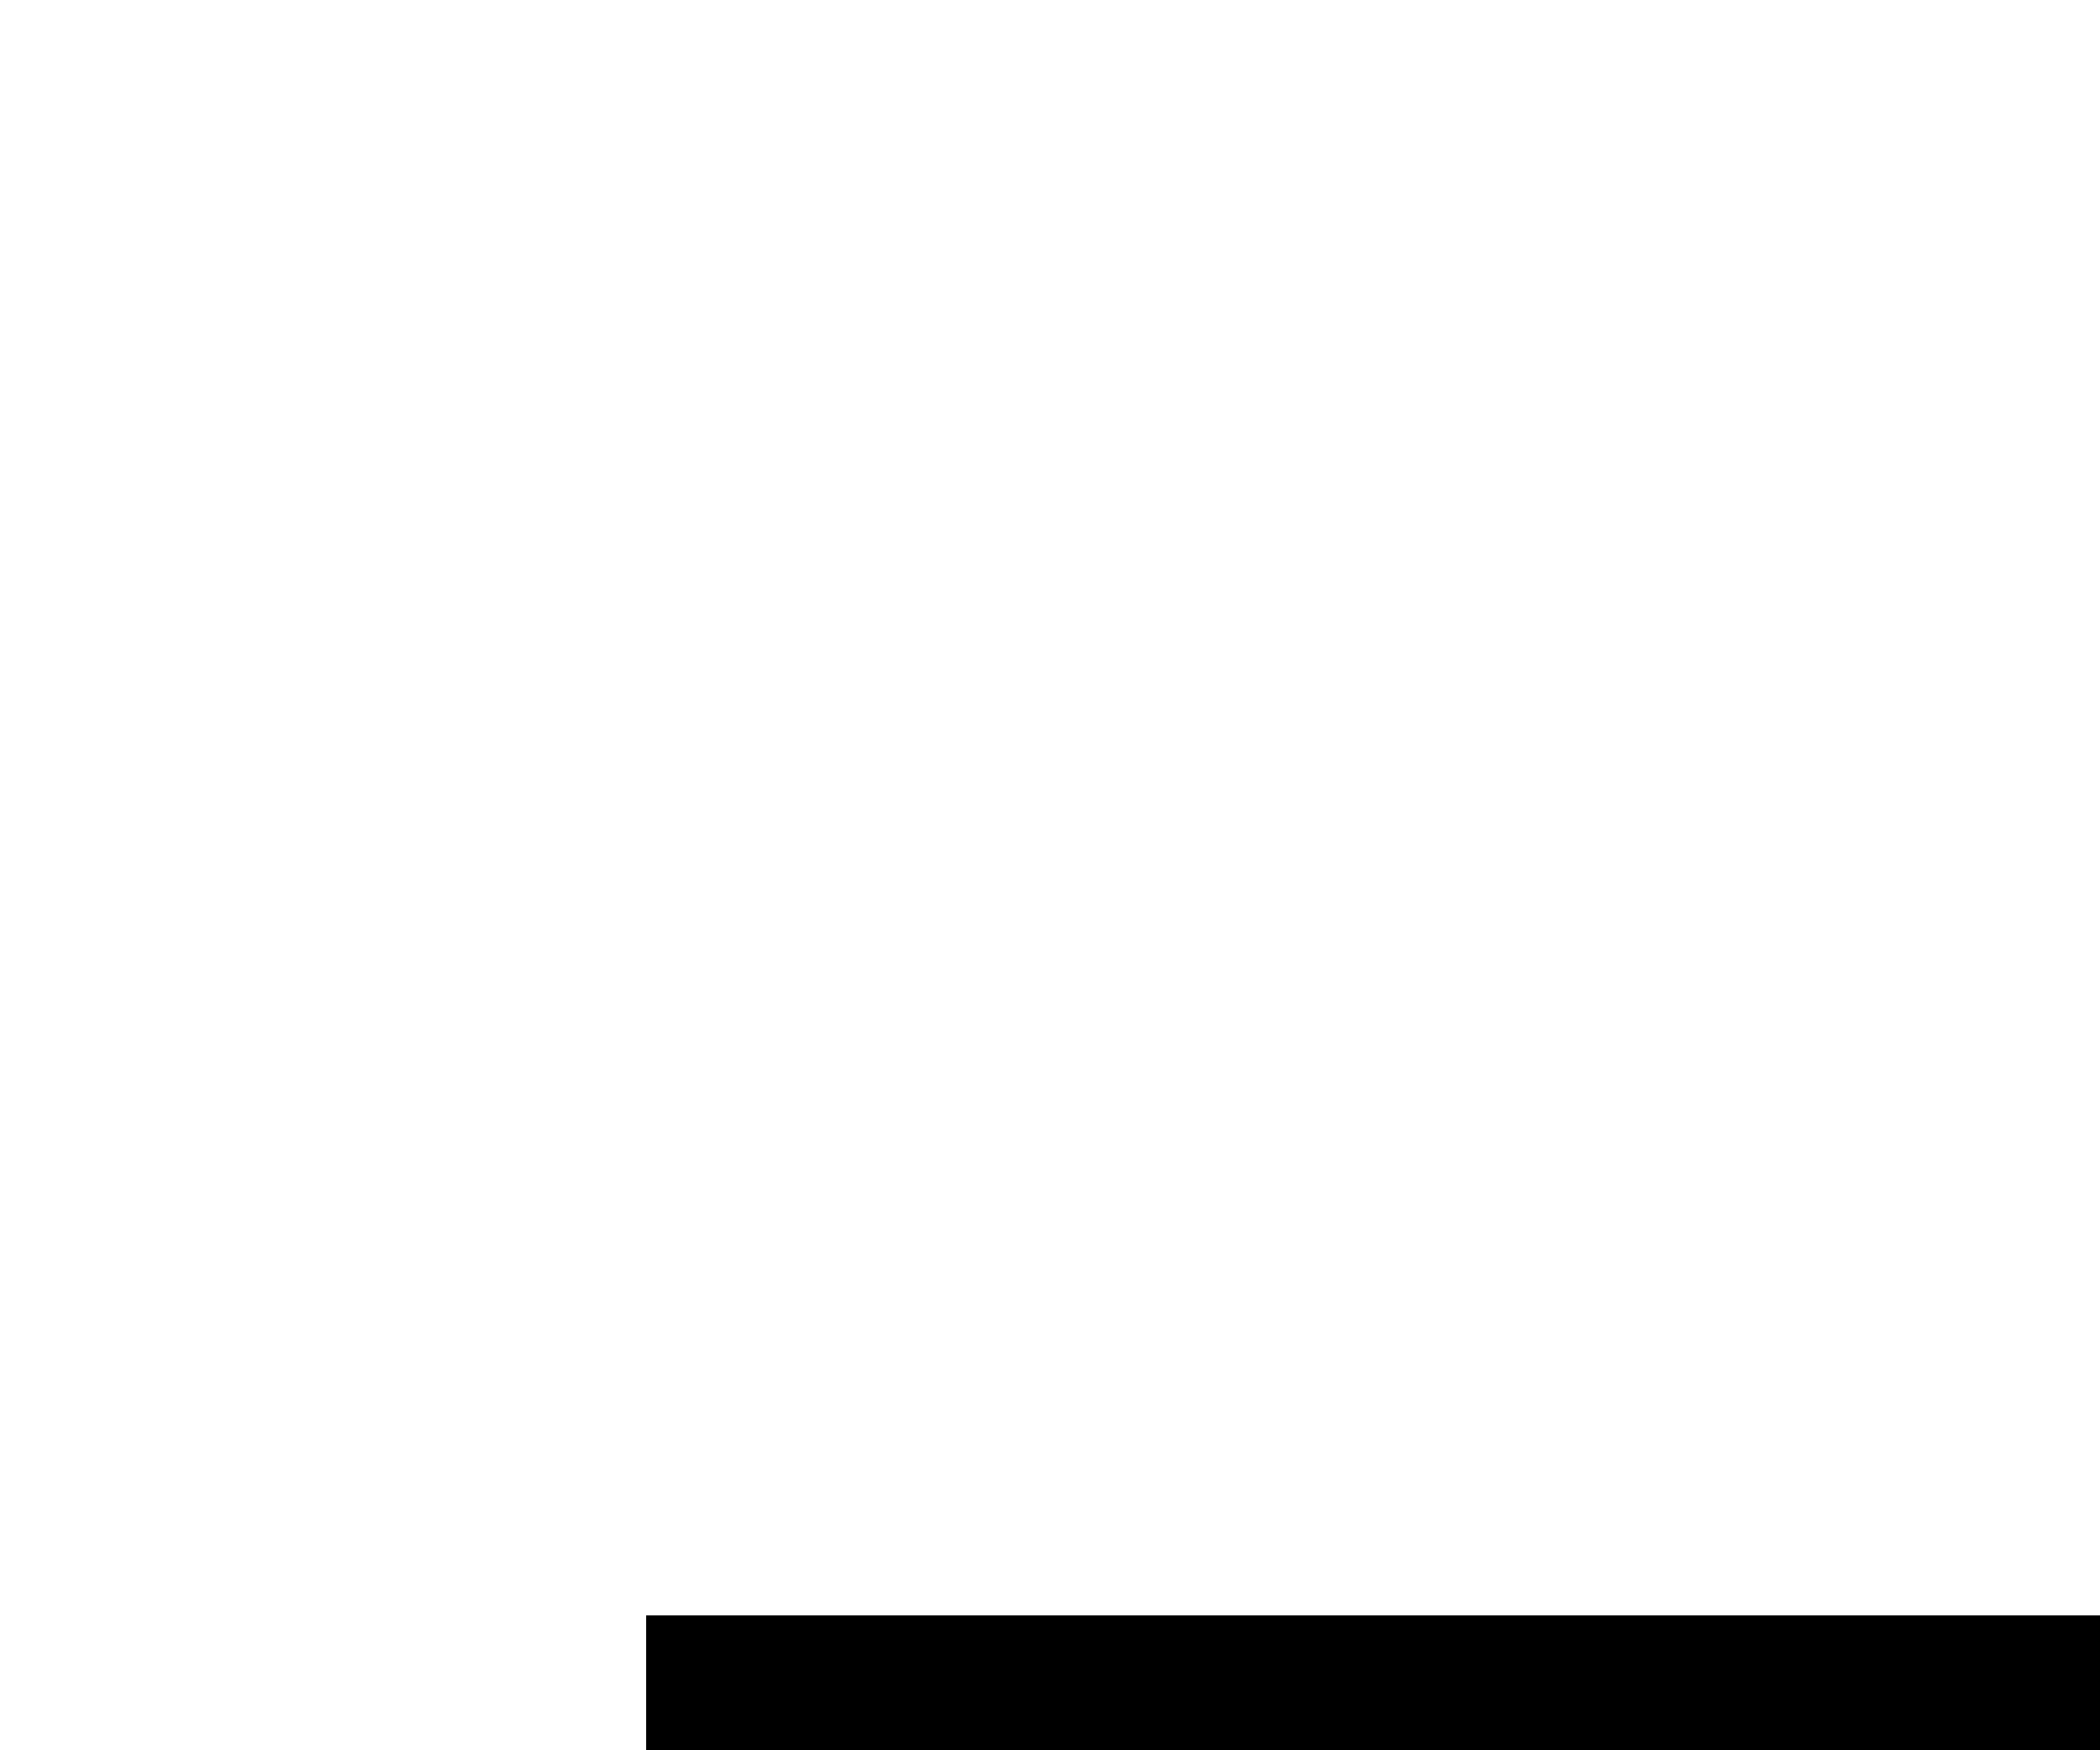
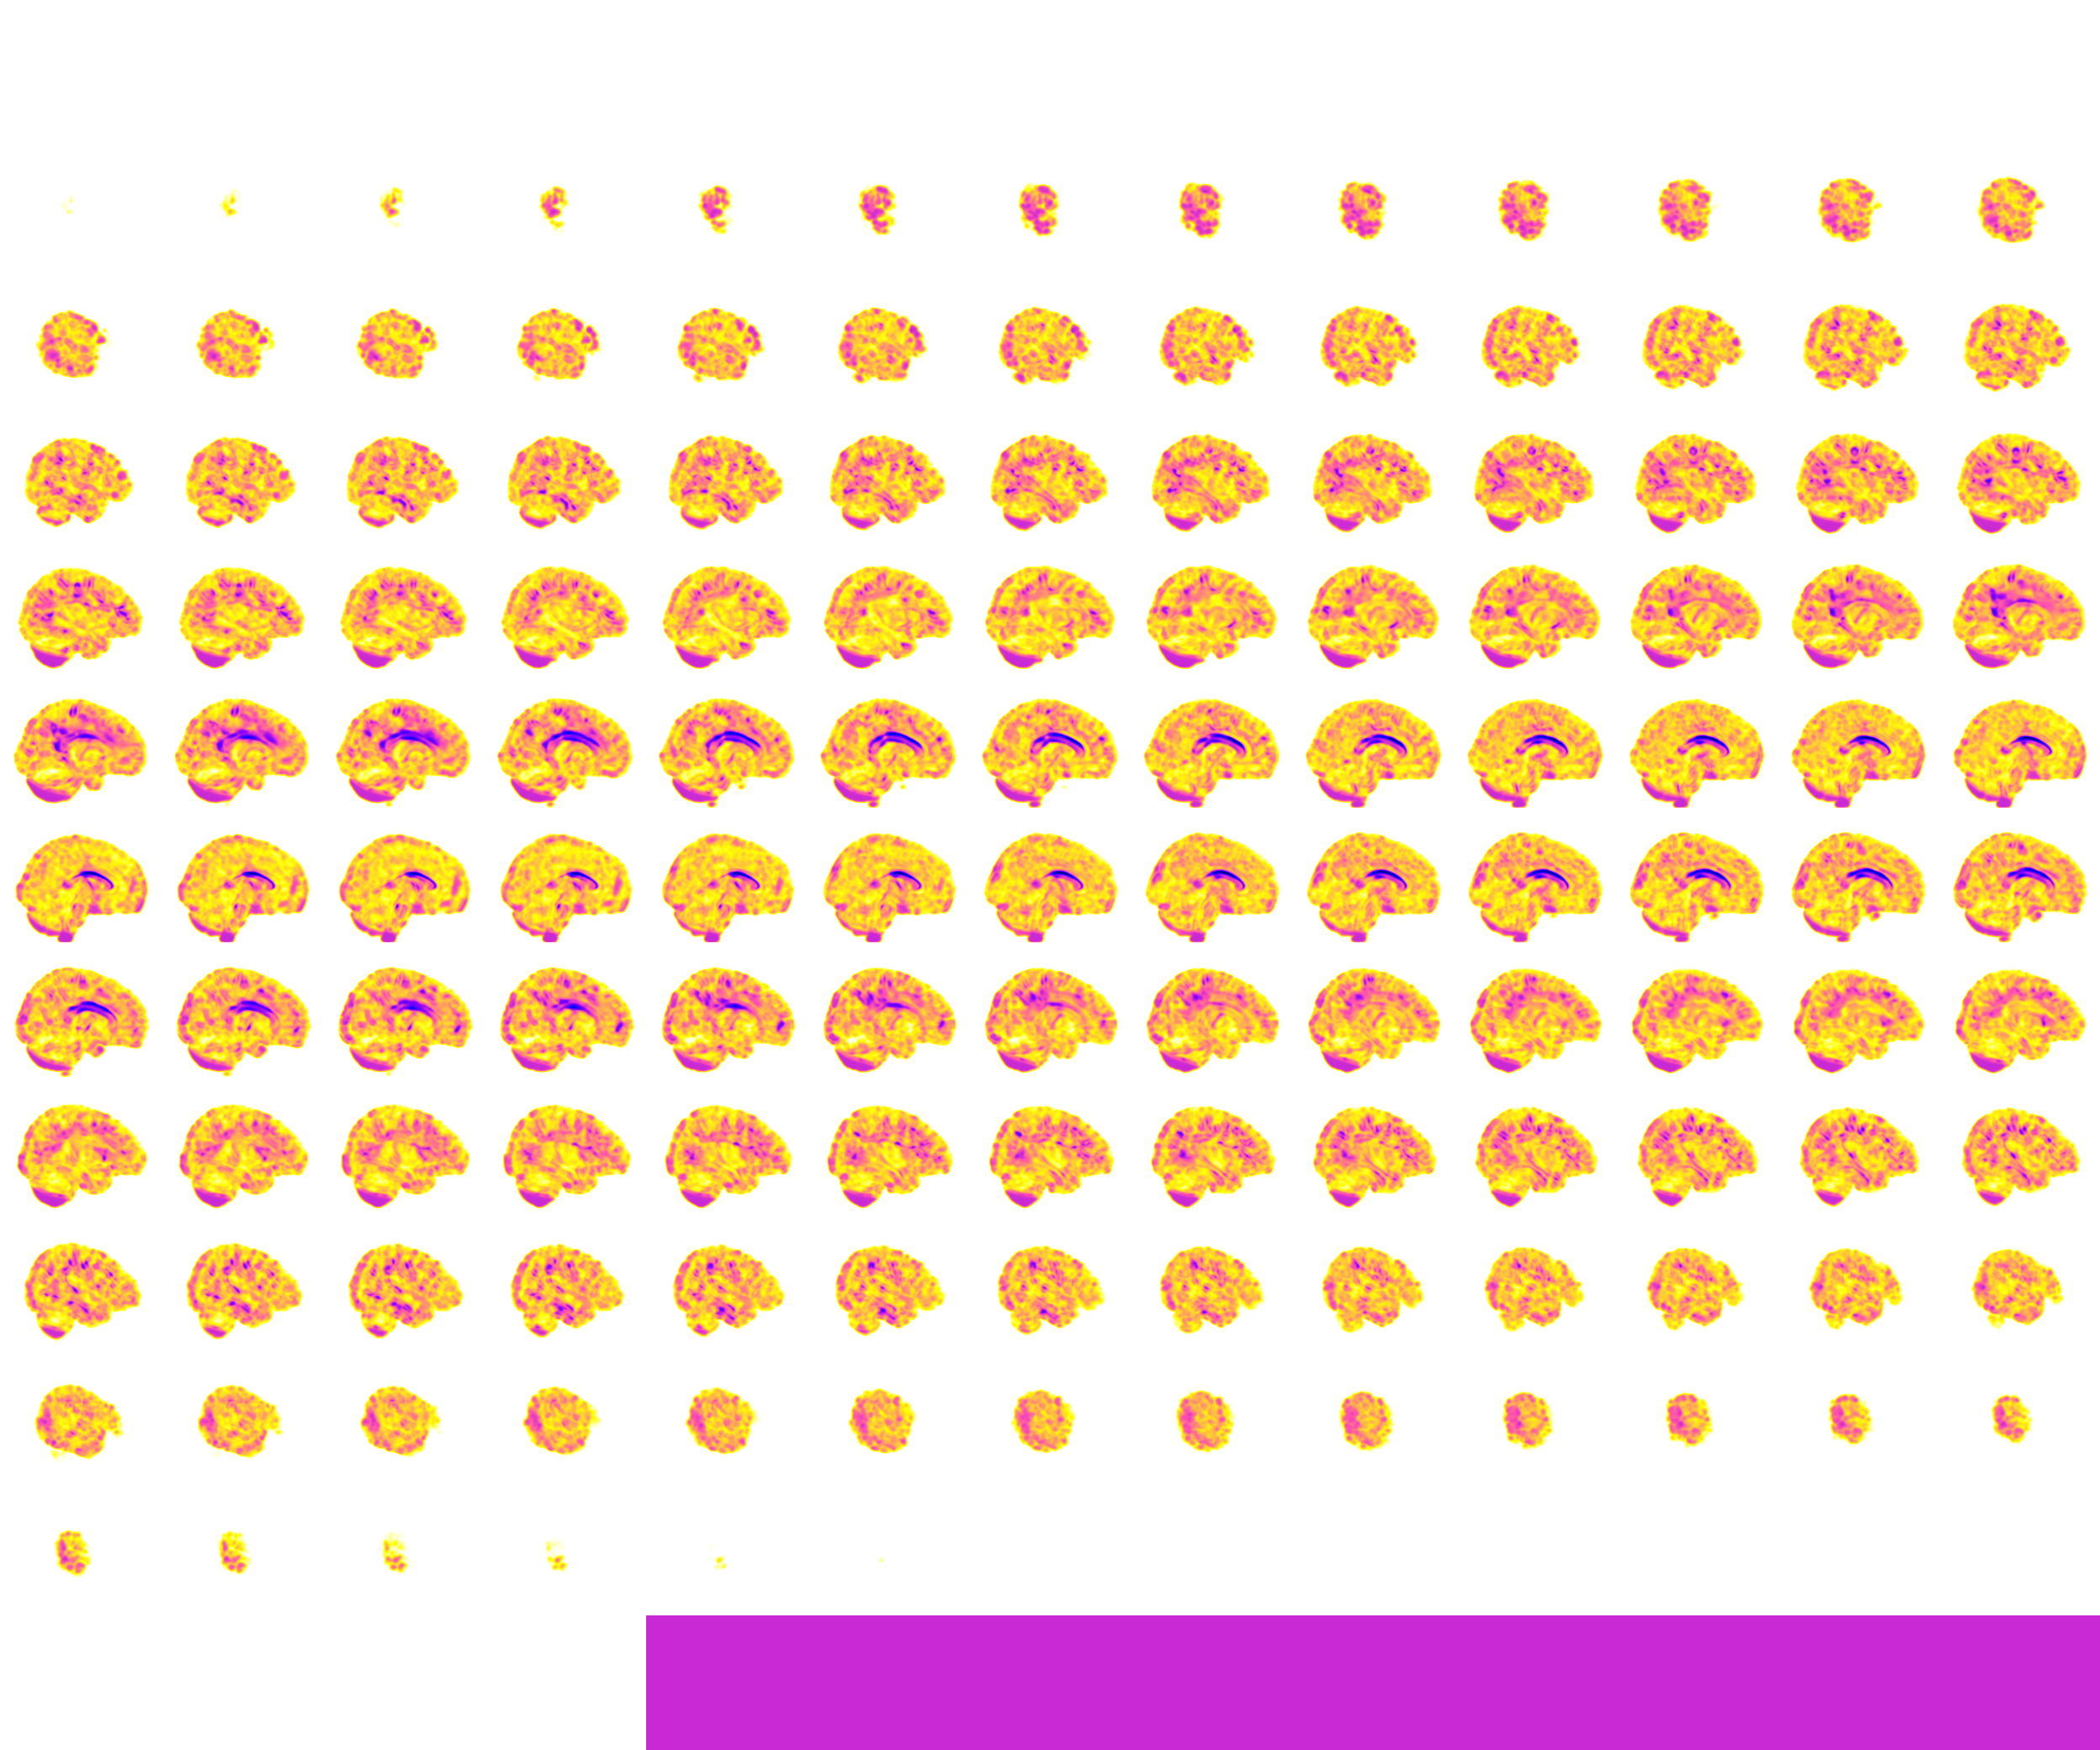

In [6]:
img_data= nib.load(fix)
ssim_t1w= nib.load(join(projectdir, 'derivatives', 'similarity_maps', 'sub-PMD1_ses-0m_desc-t1w_ssimmap.nii.gz'))
viewer = view_img(ssim_t1w, bg_img=False, title= 'Structural Similarity (T1w) ', cmap='gnuplot2')
viewer.resize(700,300)
display(viewer)

/opt/conda/lib/python3.9/site-packages/nilearn/plotting/html_stat_map.py:111: UserWarning: Threshold given was 1e-06, but the data has no values below -0.3011978268623352. 
  warnings.warn(



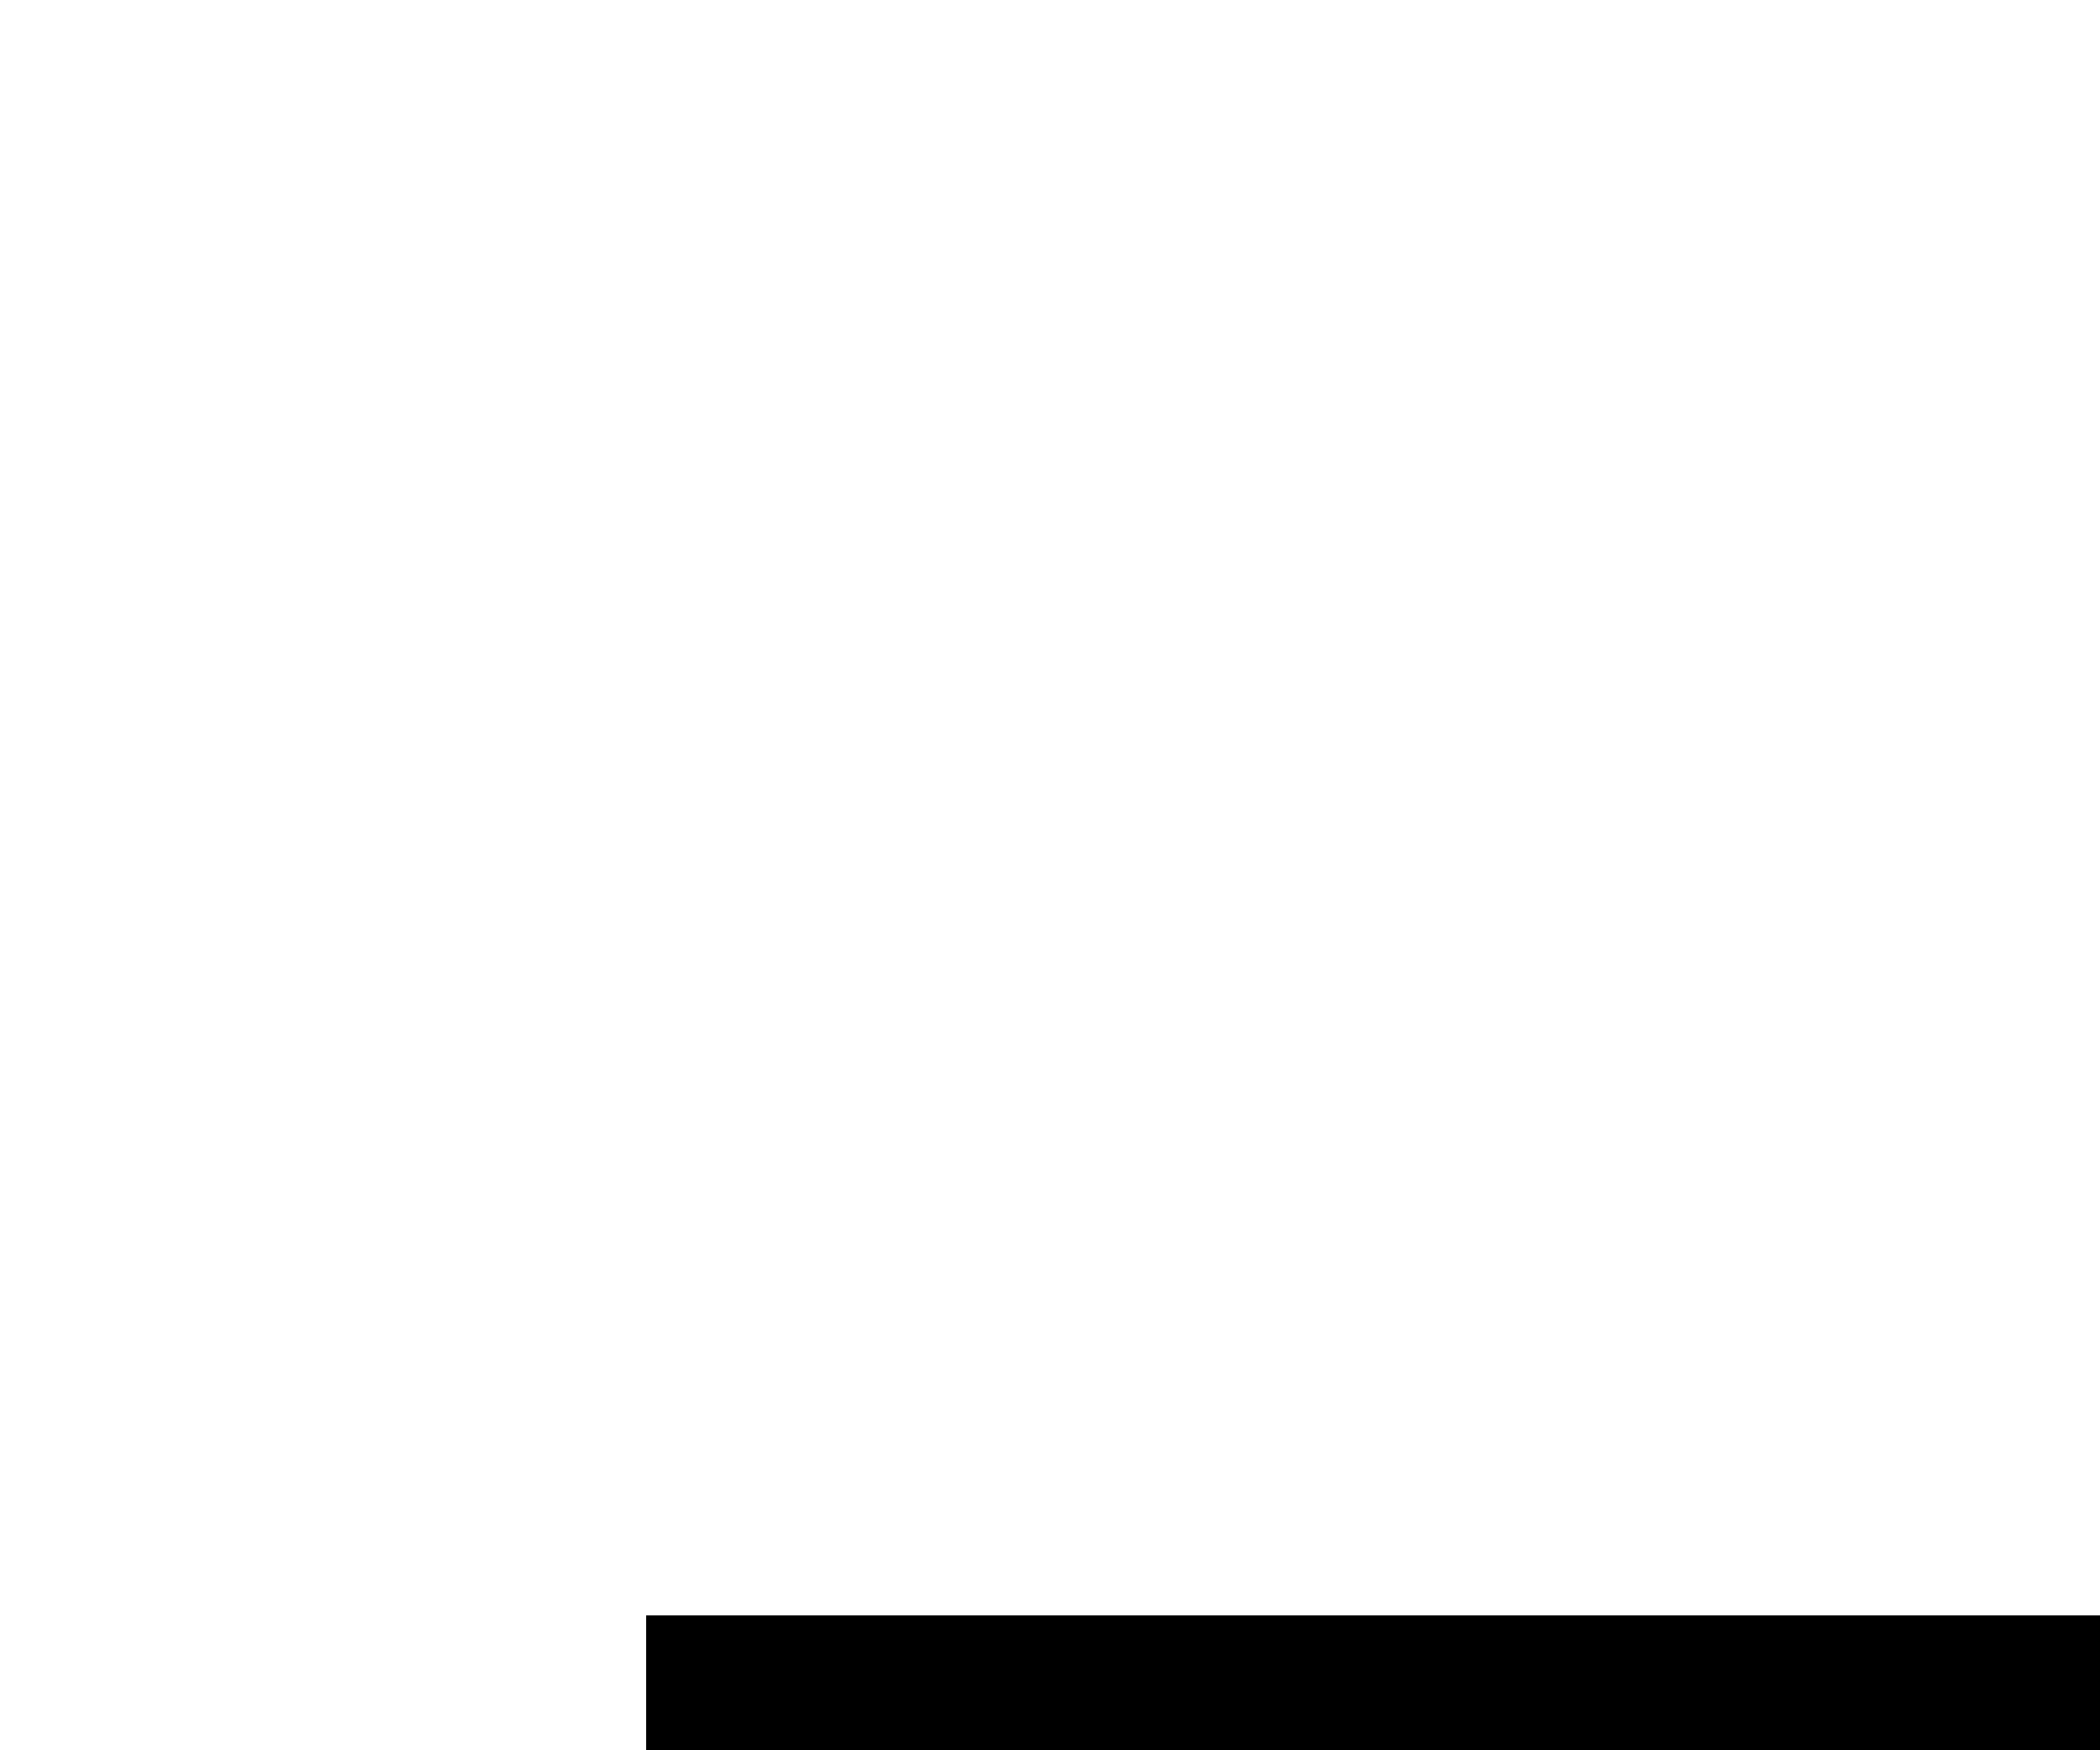
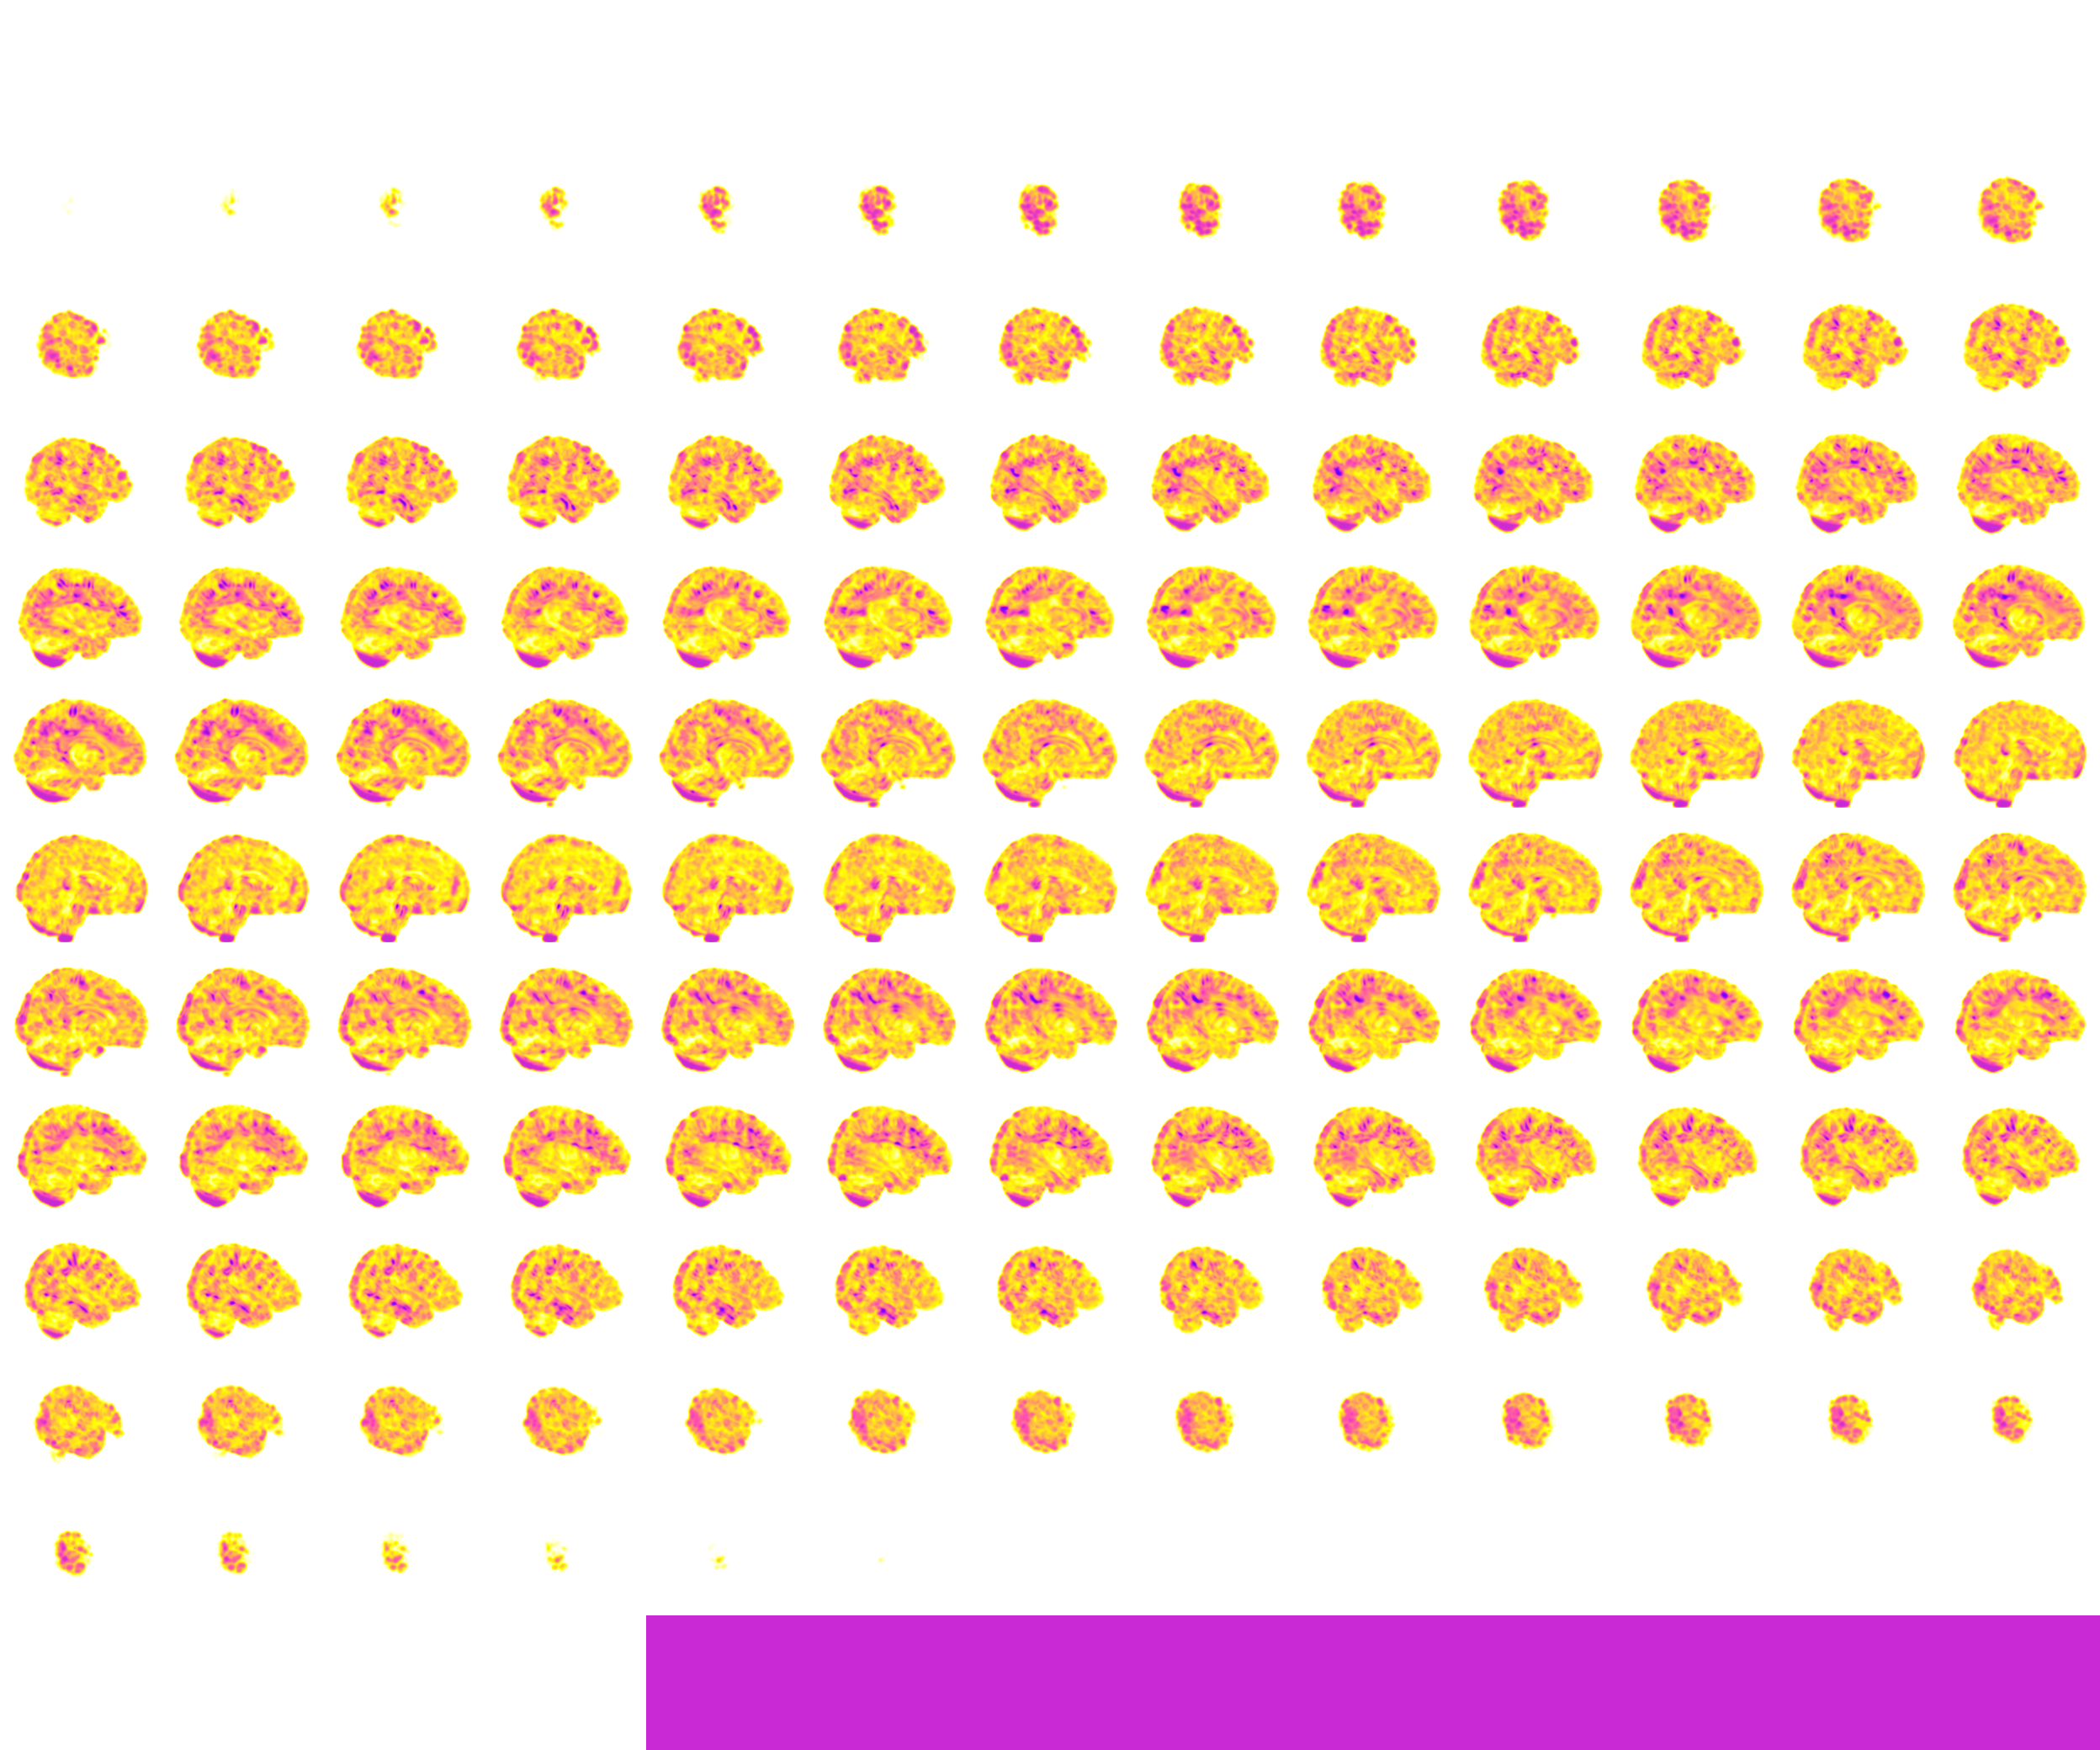

In [12]:
img_data= nib.load(fix)
ssim_multimod= nib.load(join(projectdir, 'derivatives', 'similarity_maps', 'sub-PMD1_ses-0m_desc-multimod_ssimmap.nii.gz'))
viewer = view_img(ssim_multimod, bg_img=False, title= 'Structural Similarity (multimodal)', cmap='gnuplot2')
viewer.resize(700,300)
display(viewer)

/opt/conda/lib/python3.9/site-packages/nilearn/plotting/html_stat_map.py:111: UserWarning: Threshold given was 1e-06, but the data has no values below -0.2859717905521393. 
  warnings.warn(



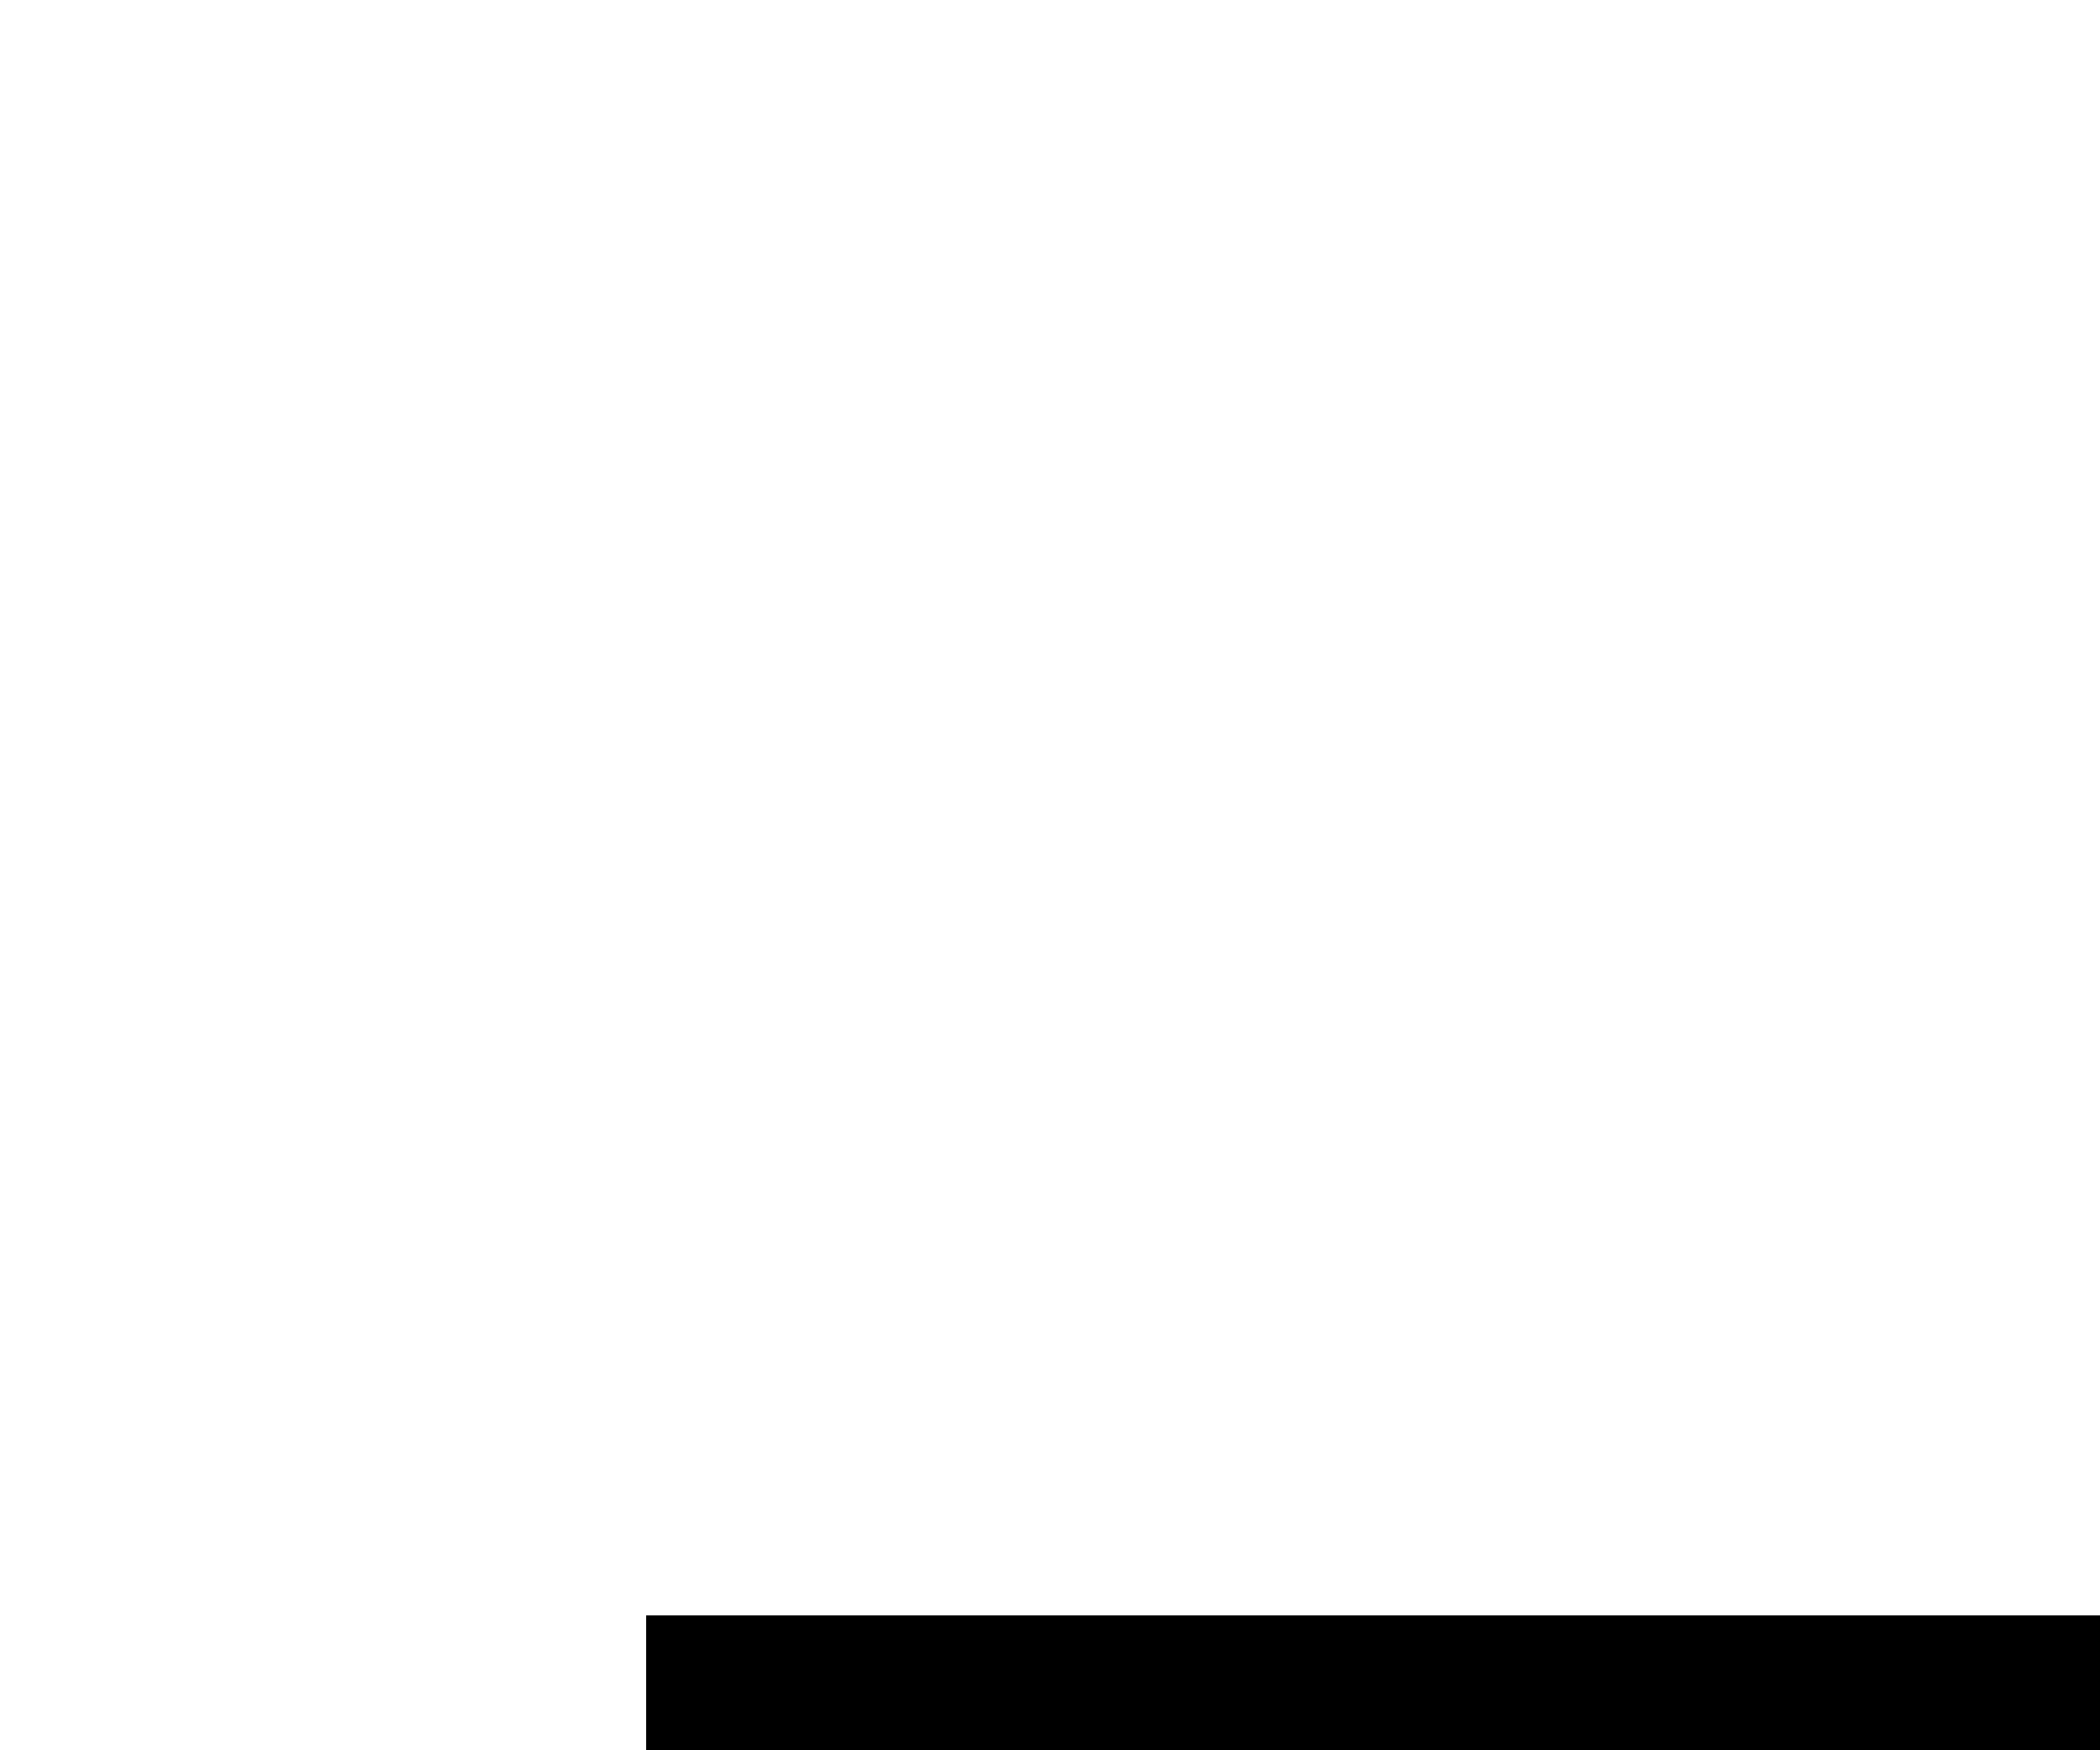
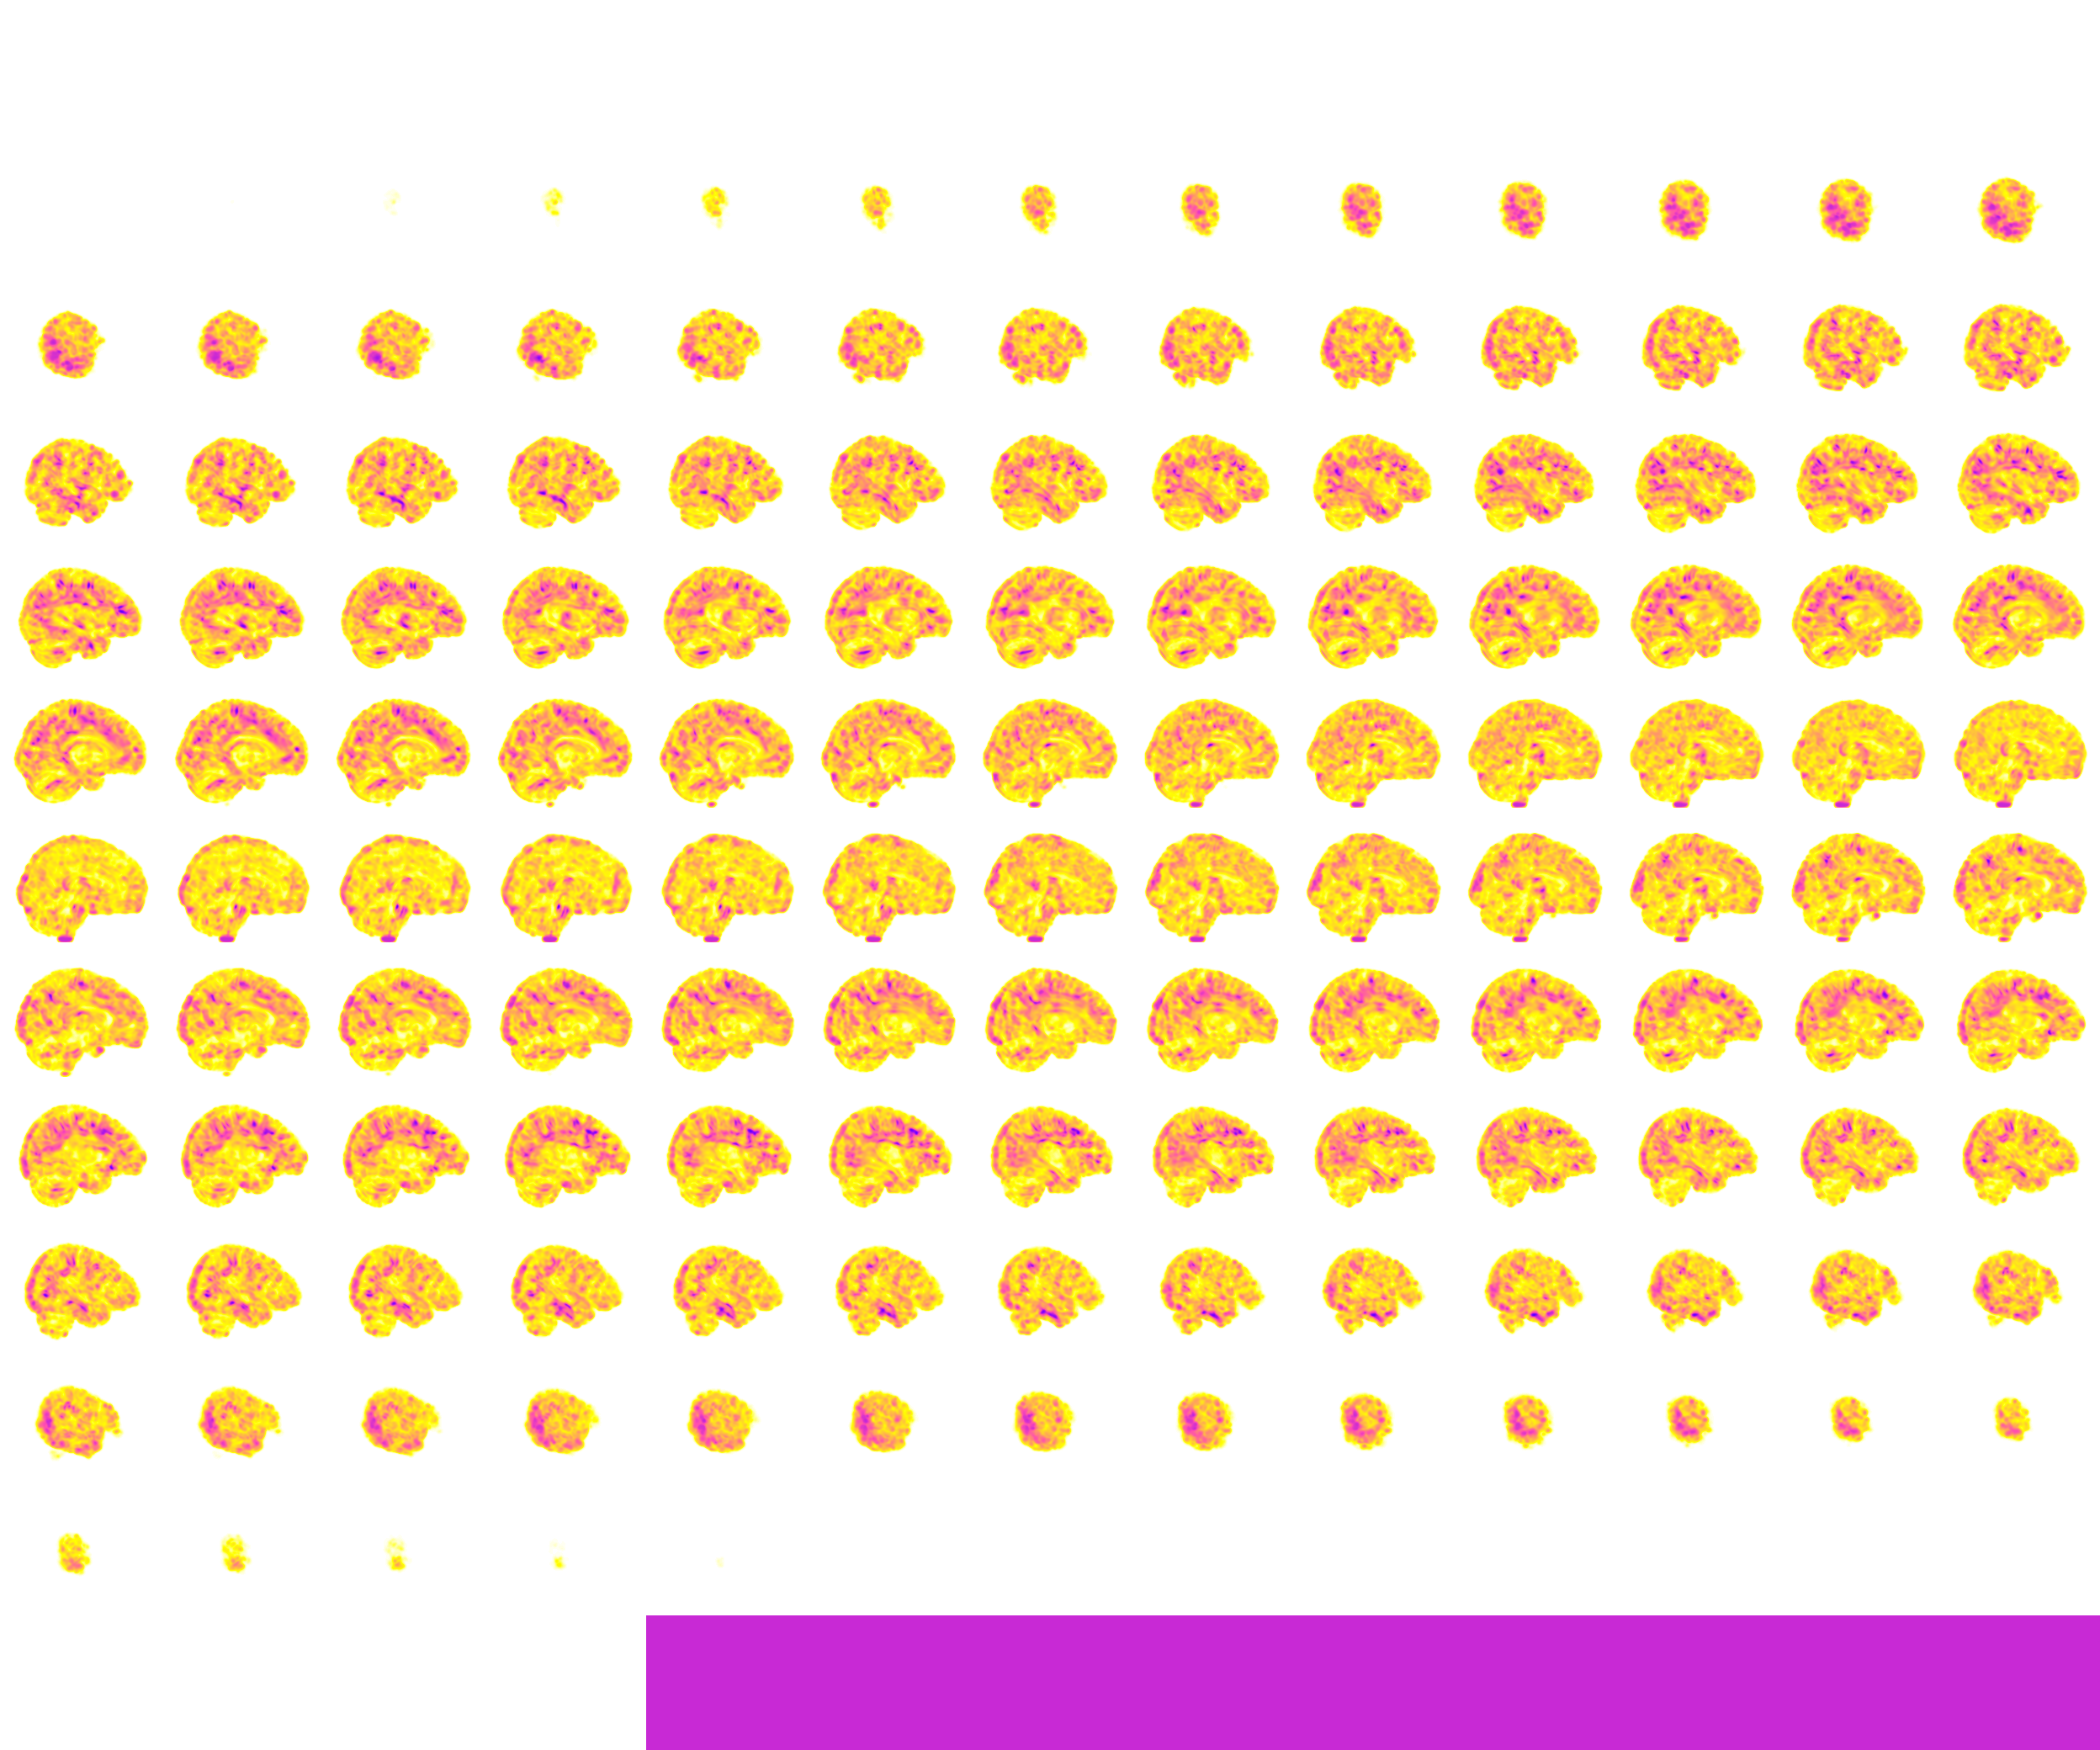

In [13]:
# show the ssim image 
ssim_fa= nib.load(join(projectdir, 'derivatives', 'similarity_maps', 'sub-PMD1_ses-0m_desc-fa_ssimmap.nii.gz'))
viewer = view_img(ssim_fa, bg_img=False, title= 'Structural Similarity (FA) ', cmap='gnuplot2')
viewer.resize(700,300)
display(viewer)

In [19]:
PMD1_regt1w=nib.load(join(projectdir,'derivatives','coreg_jhu_t1w','sub-PMD1','ses-0m','anat','sub-PMD1_ses-0m_space-jhu_desc-regT1w_fa.nii.gz'))
PMD1_regmulti=nib.load(join(projectdir,'derivatives','coreg_jhu_multimod','sub-PMD1','ses-0m','anat','sub-PMD1_ses-0m_space-jhu_desc-regmultimod_fa.nii.gz'))
PMD1_fa=nib.load(join(projectdir,'derivatives','coreg_jhu_fa','sub-PMD1','ses-0m','anat','sub-PMD1_ses-0m_space-jhu_desc-regFA_fa.nii.gz'))
jhu_tracts= nib.load(join(projectdir+ '/code/templates/JHU_pediatric/18month/dil_ventricle_atlas18m_edCK_desc-relable_atlas.nii.gz'))

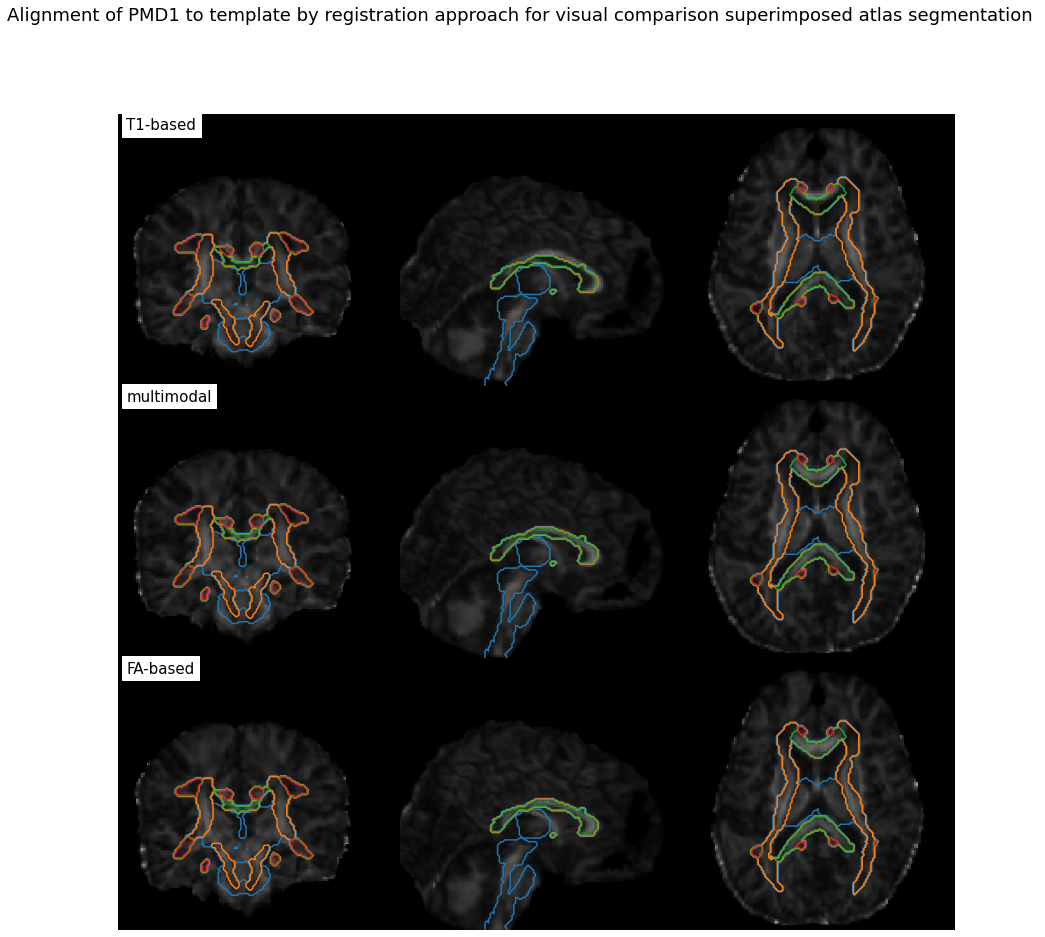

In [20]:
%matplotlib inline
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 15), sharex=True, sharey=True) 
imgs=[ PMD1_regt1w, PMD1_regmulti, PMD1_fa]
plt.subplots_adjust(wspace=0, hspace=0)

title=['T1-based', 'multimodal', 'FA-based']

for y,value in enumerate(imgs):

    display = plot_anat(imgs[y],
                draw_cross=False,
                annotate=False,axes=axes[y],  
                cut_coords= [2, -5, -8], 
                title=title[y]     )
    # add the mask
    display.add_contours(jhu_tracts, filled=False,  colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], levels=[0, 1, 2,3,4] )
    
    for cut_ax in display.axes.values():
        cut_ax.ax.set_xlim(-70, 80)
        cut_ax.ax.set_ylim(-70, 80)
fig.suptitle(f'Alignment of PMD1 to template by registration approach for visual comparison superimposed atlas segmentation ', fontsize=18)
show()